In [1]:
import os

In [2]:
os.getcwd()

'/cluster/home/klugh/MIMIC/mimic/notebooks'

In [3]:
%cd ..

/cluster/home/klugh/MIMIC/mimic


In [4]:
import json
import os
from pathlib import Path

import torch

from mimic.utils.experiment import MimicExperiment
from mimic.utils.filehandling import set_paths
from mimic.networks.VAEtrimodalMimic import VAEtrimodalMimic
from mimic.utils import plot

In [5]:
from PIL import ImageFont
try:
    font = ImageFont.truetype('FreeSerif.ttf', 38)
except:
    font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 38)

In [6]:
flags_path = os.path.expanduser('~/klugh/mimic/moe/non_factorized/Mimic_2020_10_23_13_17_46_515651/flags.rar')
FLAGS = torch.load(flags_path)

FLAGS = set_paths(FLAGS)
FLAGS.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alphabet_path = os.path.join(str(Path(os.getcwd())), 'alphabet.json')
with open(alphabet_path) as alphabet_file:
    alphabet = str(''.join(json.load(alphabet_file)))
path =os.path.expanduser('~/klugh/mimic/moe/non_factorized/Mimic_2020_10_23_13_17_46_515651/checkpoints/0299/mm_vae')
print(os.path.exists(path))

True


In [7]:
print(FLAGS.dir_data)
FLAGS.dir_data = os.path.expanduser('~/klugh')
FLAGS.dir_clf=os.path.expanduser('~/klugh/mimic/trained_classifiers/Mimic128')

/cluster/home/klugh/scratch


In [8]:
mimic_experiment = MimicExperiment(flags=FLAGS, alphabet=alphabet, font = font)


setting dataset
setting modalities
setting model
setting clfs
setting rec_weights
dict_keys(['real', 'random', '', 'PA', 'Lateral', 'text', 'Lateral_PA', 'PA_text', 'Lateral_text', 'Lateral_PA_text'])


In [9]:
mimic_experiment.mm_vae.to(FLAGS.device)

VAEtrimodalMimic(
  (encoder_pa): EncoderImg(
    (feature_extractor): FeatureExtractorImg(
      (extractor): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): Sequential(
          (0): ResidualBlock2dConv(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (dropout1): Dropout2d(p=0.5, inplace=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (dropout2): Dropout2d(p=0.5, inplace=False)
            (downsample): Sequential(
              (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [10]:
mimic_experiment.mm_vae.load_state_dict(state_dict=torch.load(path))

<All keys matched successfully>

In [11]:
num_samples = 5
random_samples = mimic_experiment.mm_vae.generate(num_samples)
epoch = 299

In [12]:
mods = mimic_experiment.modalities

random_plots = dict();
for k, m_key_in in enumerate(mods.keys()):
    mod = mods[m_key_in];
    samples_mod = random_samples[m_key_in];
    rec = torch.zeros(mimic_experiment.plot_img_size,
                      dtype=torch.float32).repeat(num_samples, 1, 1, 1);
    for l in range(0, num_samples):
        rand_plot = mod.plot_data(mimic_experiment, samples_mod[l]);
        rec[l, :, :, :] = rand_plot;
    random_plots[m_key_in] = rec;

for k, m_key in enumerate(mods.keys()):
    fn = os.path.join(mimic_experiment.flags.dir_random_samples, 'random_epoch_' +
                      str(epoch).zfill(4) + '_' + m_key + '.png');
    mod_plot = random_plots[m_key];
    p = plot.create_fig(fn, mod_plot, 10, save_figure=mimic_experiment.flags.save_figure);
    random_plots[m_key] = p;

In [18]:
print(random_plots.keys())

dict_keys(['PA', 'Lateral', 'text'])


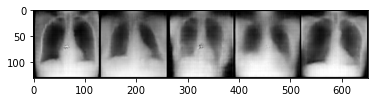

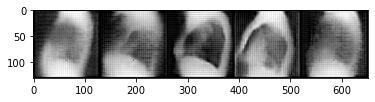

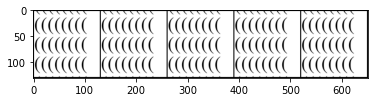

In [22]:
from matplotlib import pyplot as plt
plt.imshow(random_plots['PA'])
plt.show()
plt.imshow(random_plots['Lateral'])
plt.show()
plt.imshow(random_plots['text'])
plt.show()